In [3]:
# 국가별 군집 분석
#### 1. 데이터 전처리 ####
library(tidyverse)
library(reshape2)
library(tibble) 
library(stringr)
rdata <- list()

In [5]:
rdata$url <- c("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

In [51]:
# 날짜 및 나라별 확진자 수
rdata$confirmedCases <- read_csv(rdata$url[1]) %>% 
 select(-c(Lat,Long)) %>% melt(id=c('Country/Region','Province/State')) %>% rename("Country"=1, "State"=2, "Variable"=3, "Confirmed"=4) %>% group_by(Country, Variable) %>% summarise(Confirmed=sum(Confirmed)) %>% 
 rename("Country"=1,"Date"=2,"Confirmed"=3)

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)
See spec(...) for full column specifications.


In [52]:
# 날짜 및 나라별 사망자 수
rdata$DeathCases <- read_csv(rdata$url[2]) %>% select(-c(Lat,Long)) %>% melt(id=c('Country/Region','Province/State'))%>% 
 rename("Country"=1,State=2, "Variable"=3, "Deaths"=4) %>% 
 group_by(Country, Variable) %>% summarise(Confirmed=sum(Deaths)) %>% rename("Country"=1,"Date"=2,"Deaths"=3)

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)
See spec(...) for full column specifications.


In [53]:
# 확진자, 사망자 합치기
rdata$World <- merge(rdata$confirmedCases, rdata$DeathCases, 
 by.y=c("Country","Date")) %>% mutate(Date=as.Date(.$Date, "%m/%d/%y"))

In [54]:
rdata$World %>% head()

Country,Date,Confirmed,Deaths
Afghanistan,2020-01-22,0,0
Afghanistan,2020-01-23,0,0
Afghanistan,2020-01-24,0,0
Afghanistan,2020-01-25,0,0
Afghanistan,2020-01-26,0,0
Afghanistan,2020-01-27,0,0


In [55]:
# 타이완에 *표 없애기, 우리나라 Korea로 표현하기, 국가 이름 일치시키기
rdata$World$Country <- gsub("Taiwan\\*", "Taiwan", rdata$World$Country)
rdata$World$Country <- gsub("Korea\\, South", "Korea", rdata$World$Country)
rdata$World$Country <- gsub("North Macedonia", "Macedonia", rdata$World$Country)
rdata$World$Country <- gsub("United Kingdom", "UK", rdata$World$Country)
rdata$World$Country <- gsub("United Arab Emirates", "A.Emirates", 
 rdata$World$Country)

In [56]:
# 사망률 계산하기
head(rdata$data <- rdata$World %>% 
  mutate(DeathRate=ifelse(Confirmed==0, 0, 100*Deaths/Confirmed)) %>%
  arrange(Country, Date))

Country,Date,Confirmed,Deaths,DeathRate
A.Emirates,2020-01-22,0,0,0
A.Emirates,2020-01-23,0,0,0
A.Emirates,2020-01-24,0,0,0
A.Emirates,2020-01-25,0,0,0
A.Emirates,2020-01-26,0,0,0
A.Emirates,2020-01-27,0,0,0


In [59]:
#### 나. 나라별 인구수와 국가를 신뢰하는 정도 ####
rdata$Population <- read_csv("https://raw.githubusercontent.com/cysics/COVID-19/master/data/Population.csv") %>% 
 filter(Year=="2019") %>% select(c(1,3))   # 인구는 2019년 기준

rdata$Trust <- read_csv("https://raw.githubusercontent.com/cysics/COVID-19/master/data/Trust.csv") # 인구는 2018년 기준

head(rdata$TrustP <- merge(rdata$Trust, rdata$Population, by='Country'))

Parsed with column specification:
cols(
  Country = col_character(),
  Year = col_double(),
  Population = col_double()
)
Parsed with column specification:
cols(
  Country = col_character(),
  Trust = col_double()
)


Country,Trust,Population
Afghanistan,45.19529,38042000
Albania,46.44411,2881000
Algeria,38.05931,43053000
Argentina,31.92407,44781000
Armenia,79.74244,2958000
Australia,46.97924,25203000


In [60]:

# 이름 일치시키기(페로, 홍콩, 팔레스타인 제외)
rdata$TrustP$Country <- gsub("South Korea", "Korea", rdata$TrustP$Country)
rdata$TrustP$Country <- gsub("United States", "US", rdata$TrustP$Country)
rdata$TrustP$Country <- gsub("Czech Republic", "Czechia", 
 rdata$TrustP$Country)
rdata$TrustP$Country <- gsub("United Kingdom", "UK", rdata$TrustP$Country)
rdata$World$Country <- gsub("Bahamas, The", "Bahamas", rdata$World$Country)
rdata$World$Country <- gsub("North Macedonia", "Macedonia", rdata$World$Country)
rdata$World$Country <- gsub("Gambia, The", "Gambia", rdata$World$Country)
rdata$World$Country <- gsub("East Timor", "Timor", rdata$World$Country)

In [61]:
#### 다. 다 합치기 ####
# 검사자 수, 인구, 확진자, 사망자, 완치자 데이터 모두 합치기
rdata$data <- merge(rdata$TrustP, rdata$World, by='Country')

In [62]:
# 백만명당 확진자, 사망자 구하기
rdata$data <- rdata$data %>% mutate(ConfirmedperM=Confirmed*1000000/Population) %>% 
 mutate(DeathsperM=Deaths*1000000/Population)


In [33]:
#### 2. 군집분석 ####
library(pheatmap) 
library(NbClust) 
library(factoextra)

Warning message:
"package 'pheatmap' was built under R version 3.6.3"Warning message:
"package 'factoextra' was built under R version 3.6.3"Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


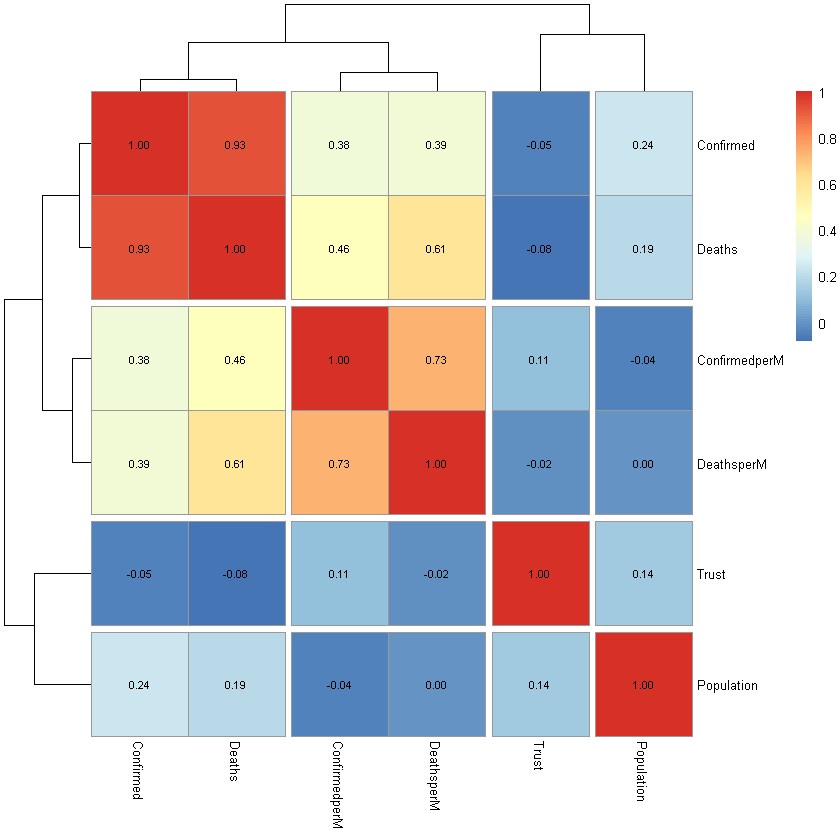

In [63]:
#### 가. 기본 변수간 군집분석 ####
data <- rdata$data %>% filter(Date=="2020-05-01") %>% 
 select(-c("Country", "Date"))

pheatmap(cor(data, method="pearson"), cutree_rows=4, cutree_cols=4,
 display_numbers=T, fontsize=8, number_format="%.2f", number_color="grey0")

In [65]:
#### 나. 코로나19 확산 관련 ####
# 1000명 이상의 확진자를 낸 국가들 ####
rdata$data %>% group_by(Country) %>% filter(Date<Sys.Date()) %>% 
 filter(Confirmed>=1000) %>% distinct(Country) %>% .$Country

[1] "Afghanistan"            "Algeria"                "Argentina"             
 [4] "Armenia"                "Australia"              "Austria"               
 [7] "Azerbaijan"             "Bangladesh"             "Belarus"               
[10] "Belgium"                "Bolivia"                "Bosnia and Herzegovina"
[13] "Brazil"                 "Bulgaria"               "Cameroon"              
[16] "Canada"                 "Chile"                  "Colombia"              
[19] "Cote d'Ivoire"          "Croatia"                "Czechia"               
[22] "Denmark"                "Dominican Republic"     "Ecuador"               
[25] "Estonia"                "Finland"                "France"                
[28] "Germany"                "Ghana"                  "Greece"                
[31] "Guinea"                 "Hungary"                "Iceland"               
[34] "India"                  "Indonesia"              "Iran"                  
[37] "Iraq"                   "Ireland"                "Israel"                
[40] "Italy"                  "Japan"                  "Kazakhstan"            
[43] "Korea"                  "Lithuania"              "Luxembourg"            
[46] "Macedonia"              "Malaysia"               "Mexico"                
[49] "Moldova"                "Morocco"                "Netherlands"           
[52] "New Zealand"            "Nigeria"                "Norway"                
[55] "Pakistan"               "Panama"                 "Peru"                  
[58] "Philippines"            "Poland"                 "Portugal"              
[61] "Romania"                "Russia"                 "Senegal"               
[64] "Serbia"                 "Singapore"              "Slovakia"              
[67] "Slovenia"               "South Africa"           "Spain"                 
[70] "Sweden"                 "Switzerland"            "Thailand"              
[73] "Turkey"                 "UK"                     "Ukraine"               
[76] "US"                     "Uzbekistan"

In [66]:
cutoff <-10000

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


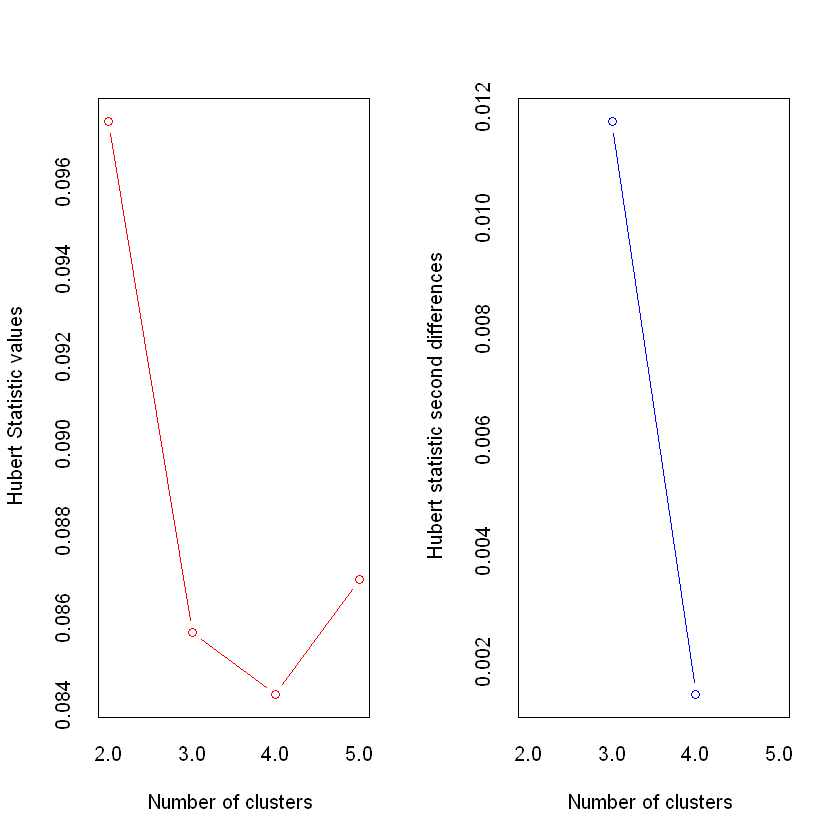

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 9 proposed 2 as the best number of clusters 
* 10 proposed 3 as the best number of clusters 
* 2 proposed 4 as the best number of clusters 
* 2 proposed 5 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  3 
 
 
******************************************************************* 


$All.index
      KL      CH Hartigan     CCC   Scott Marriot  TrCovW TraceW Friedman
2 0.9394  7.8161   9.1095 -0.6773 18.6268 36.8841 14.2596 9.1198  11.5328
3 2.5169 11.9968   4.5573 -0.1073 42.7664  4.0603  1.1290 3.6215  34.9893
4 2.3474 13.4454   2.1574 -0.2553 51.7174  2.3578  0.3953 1.8946  45.7260
5 0.6334 12.0466   3.9932 -1.2208 67.4273  0.5170  0.0838 1.2308 101.9008
    Rubin Cindex     DB Silhouette   Duda Pseudot2   Beale Ratkowsky   Ball
2  2.3027 0.5587 0.3098     0.6140 0.3971   7.5912  2.1539    0.4999 4.5599
3  5.7987 0.4058 0.5824     0.5030 0.5693   1.5128  0.8585    0.5243 1.2072
4 11.0841 0.5191 0.4157     0.5424 1.4120  -0.2918 -0.2484    0.4768 0.4737
5 17.0621 0.4176 0.3751     0.5995 0.8033   0.2448  0.2084    0.4339 0.2462
  Ptbiserial   Frey McClain   Dunn Hubert SDindex Dindex   SDbw
2     0.8414 2.3369  0.1440 1.1994 0.0974  1.2290 0.9752 0.3097
3     0.6349 0.7131  0.9154 0.6809 0.0857  1.3784 0.5736 0.1455
4     0.5799 1.9251  1.3798 0.8633 0.0842  1.5889 0.4096 0.0696
5     0.4763 0.6194  2.2147 0.8575 0.0869  2.3199 0.2967 0.0470

$All.CriticalValues
  CritValue_Duda CritValue_PseudoT2 Fvalue_Beale
2        -0.0559           -94.5213       0.1361
3        -0.3282            -8.0930       0.5116
4        -0.5009            -2.9964       1.0000
5        -0.5009            -2.9964       0.8849

$Best.nc
                    KL      CH Hartigan     CCC   Scott Marriot  TrCovW TraceW
Number_clusters 3.0000  4.0000   3.0000  3.0000  3.0000  3.0000  3.0000 3.0000
Value_Index     2.5169 13.4454   4.5522 -0.1073 24.1396 31.1213 13.1305 3.7714
                Friedman  Rubin Cindex     DB Silhouette   Duda PseudoT2  Beale
Number_clusters   5.0000 4.0000 3.0000 2.0000      2.000 2.0000       NA 2.0000
Value_Index      56.1748 0.6928 0.4058 0.3098      0.614 0.3971       NA 2.1539
                Ratkowsky   Ball PtBiserial   Frey McClain   Dunn Hubert
Number_clusters    3.0000 3.0000     2.0000 2.0000   2.000 2.0000      0
Value_Index        0.5243 3.3527     0.8414 2.3369   0.144 1.1994      0
                SDindex Dindex  SDbw
Number_clusters   2.000      0 5.000
Value_Index       1.229      0 0.047

$Best.partition
 France  Turkey  Russia      UK   Italy Germany   Spain      US 
      1       2       2       1       1       2       1       3

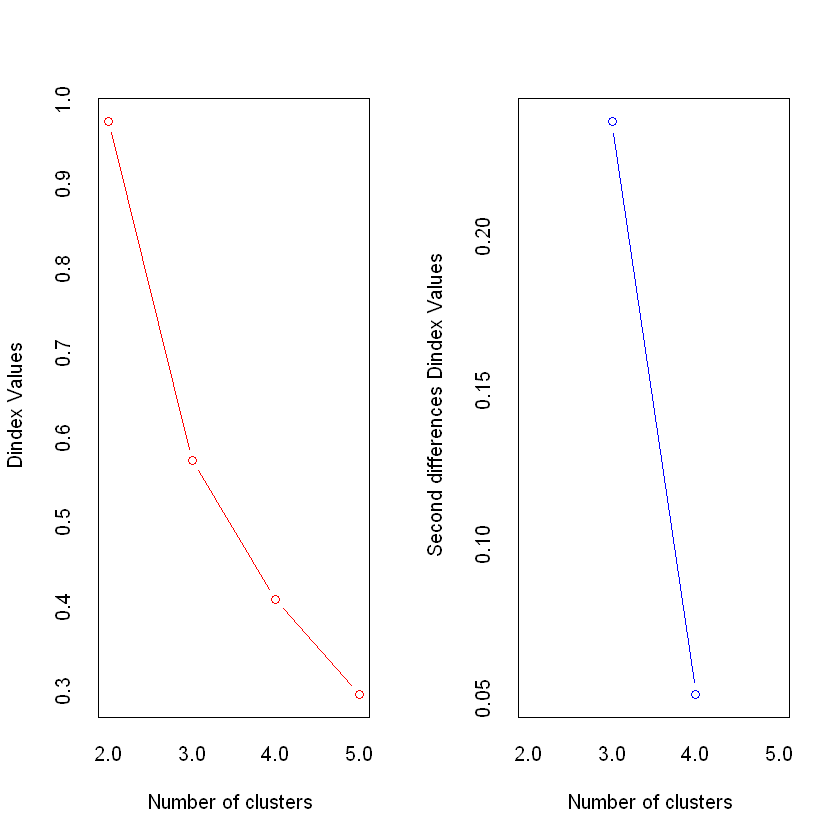

In [68]:
data <- rdata$data %>% group_by(Country) %>% 
 filter(max(Confirmed)>=cutoff*10) %>% 
 filter(Confirmed>=cutoff & Confirmed<=cutoff*10) %>% 
 mutate(Days=max(Date)-min(Date)) %>% arrange(desc(Days)) %>% 
 mutate(Days=as.numeric(as.character(Days))) %>% filter(Date==max(Date)) %>% 
 select(c("Country", "Date", "Trust", "Days", "Confirmed", "Deaths")) %>% 
 ungroup() %>% column_to_rownames("Country") %>% 
 select(c("Days", "Confirmed", "Deaths"))

NbClust(scale(data), distance="euclidean", min.nc=2, max.nc=5, method="average")
# 군집수 추천 : cutoff5000(3개)

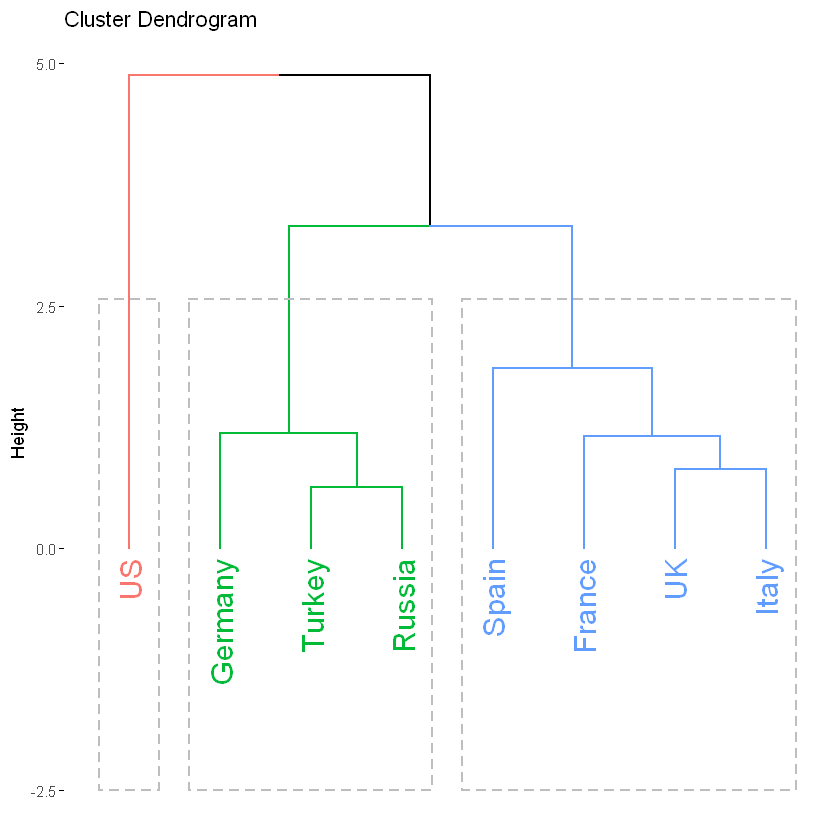

In [70]:
rdata$fit.hc <- data %>%  scale() %>% dist(method="euclidean") %>% 
 hclust(method="ward.D2")
# manhanttan or euclidean 유클리드 제곱거리(single, complete, average, mcquitty, median or centroid), 오차제곱합(ward.D, ward.D2)

fviz_dend(rdata$fit.hc, cex=1.3, labels_track_height=2, k=3,    #cutoff=10000
 color_labels_by_k=T, rect=T)

10,000에서 100,000으로 확진자가 증가한 국가들의 특성에 따라 묶어보았음.
 군집에 사용된 feature ; trust, population, confirmed, death, date
US가 독보적으로 구분되고 있는 것을 볼 수 있음(가장 빠른 증가율)


나라별? 어떤 특성이 있는지?

In [84]:
#loading data
setwd("C:/Users/seung/OneDrive/R/Dacon/Dataset")
case <- read_csv("Case.csv")
patient_info <- read_csv("PatientInfo.csv")
patient_route <- read_csv("PatientRoute.csv")
region <- read_csv("Region.csv")
search_trend <- read_csv("SearchTrend.csv")
seoul_floating <- read_csv("SeoulFloating.csv")
time <- read_csv("Time.csv")
time_age <- read_csv("TimeAge.csv")
time_gender <- read_csv("TimeGender.csv")
time_province <- read_csv("TimeProvince.csv")
weather <- read_csv("Weather.csv")
policy <- read_csv("Policy.csv")


Parsed with column specification:
cols(
  case_id = col_double(),
  province = col_character(),
  city = col_character(),
  group = col_logical(),
  infection_case = col_character(),
  confirmed = col_double(),
  latitude = col_character(),
  longitude = col_character()
)
Parsed with column specification:
cols(
  patient_id = col_double(),
  global_num = col_double(),
  sex = col_character(),
  birth_year = col_double(),
  age = col_character(),
  country = col_character(),
  province = col_character(),
  city = col_character(),
  disease = col_logical(),
  infection_case = col_character(),
  infection_order = col_double(),
  infected_by = col_double(),
  contact_number = col_double(),
  symptom_onset_date = col_date(format = ""),
  confirmed_date = col_date(format = ""),
  released_date = col_date(format = ""),
  deceased_date = col_date(format = ""),
  state = col_character()
)
Parsed with column specification:
cols(
  patient_id = col_double(),
  global_num = col_double(),
  date = 

Classes 'spec_tbl_df', 'tbl_df', 'tbl' and 'data.frame':	450 obs. of  5 variables:
 $ date     : Date, format: "2020-03-02" "2020-03-02" ...
 $ time     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ age      : chr  "0s" "10s" "20s" "30s" ...
 $ confirmed: num  32 169 1235 506 633 ...
 $ deceased : num  0 0 0 1 1 5 6 6 3 0 ...
 - attr(*, "spec")=
  .. cols(
  ..   date = col_date(format = ""),
  ..   time = col_double(),
  ..   age = col_character(),
  ..   confirmed = col_double(),
  ..   deceased = col_double()
  .. )


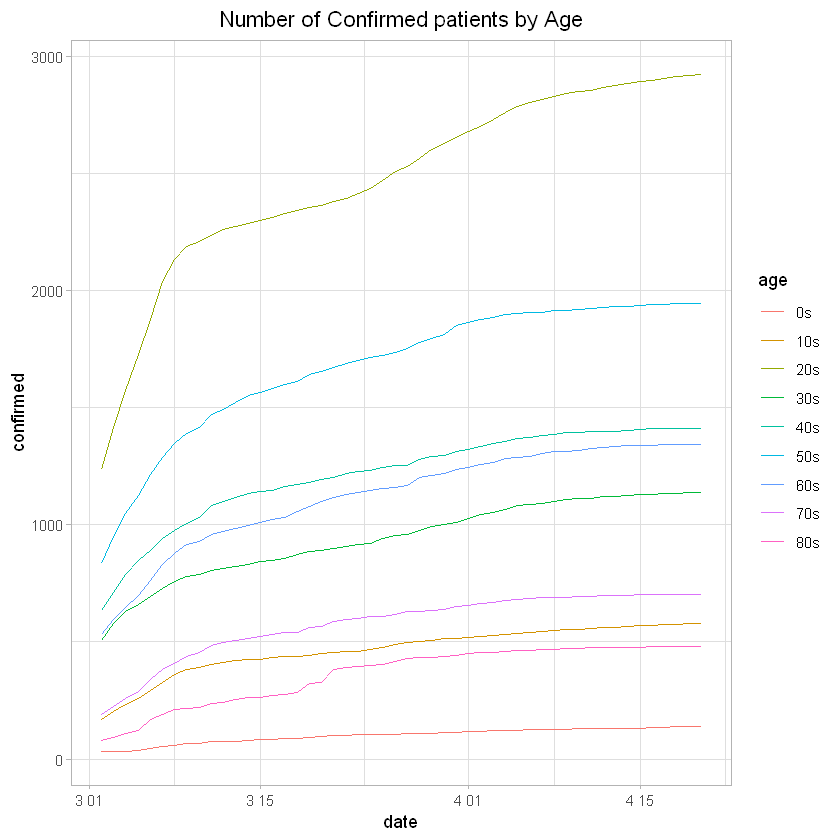

In [85]:
# 연령대별 확진자 분포
str(time_age)
time_age %>% 
 ggplot(aes(date, confirmed))+
 geom_line(aes(group=age, color=age))+
 theme_light()+
 ggtitle("Number of Confirmed patients by Age")+
 theme(plot.title = element_text(hjust=0.5))

In [88]:
# 정책 - 사회적 거리두기

social <- policy %>% filter(type == 'Social') %>% select(gov_policy,detail,start_date,end_date)


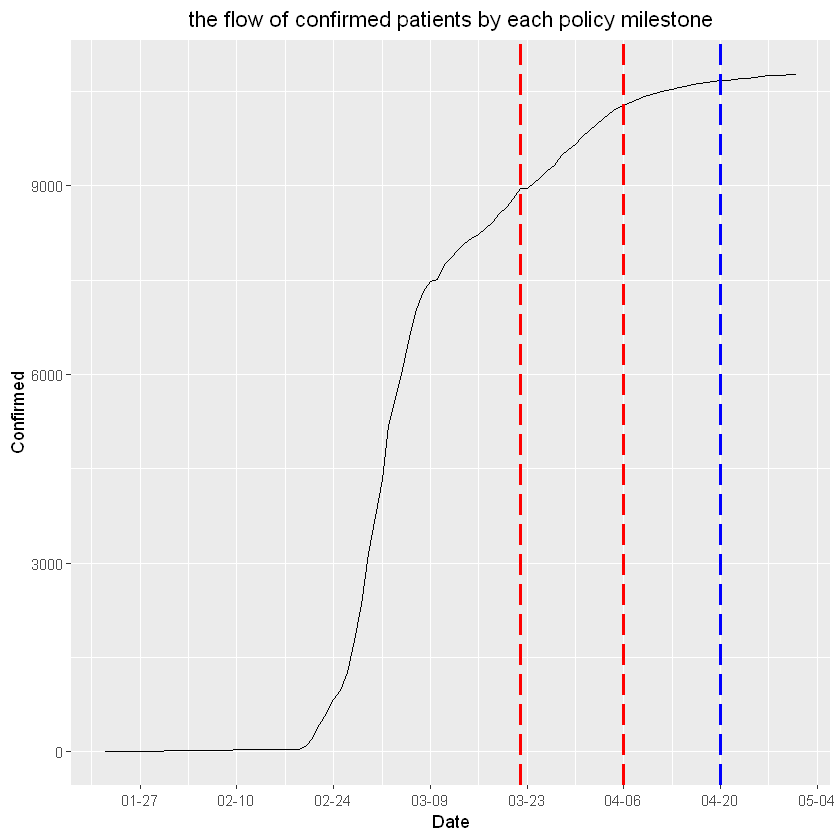

In [91]:
korea <- covid19 %>% filter(Country == 'Korea') %>% as_tibble()
result <- ggplot(korea, aes(x=Date, y=Confirmed)) +
 geom_line() +
 scale_x_date(date_breaks = "2 week", date_labels = "%m-%d") + 
 scale_y_continuous() +
 ggtitle("the flow of confirmed patients by each policy milestone") + 
 theme(plot.title = element_text(hjust = 0.5)) +
 geom_vline(xintercept = as.Date("2020-03-22", "%Y-%m-%d"), linetype="longdash",  color = "red", size=1)+
 geom_vline(xintercept = as.Date("2020-04-06", "%Y-%m-%d"), linetype="longdash",  color = "red", size=1)+
 geom_vline(xintercept = as.Date("2020-04-20", "%Y-%m-%d"), linetype="longdash",  color = "blue", size=1)
result

 확진자 급직적 증가한 일자 2020-02-18
 사망자 정점 일자 2020-02-29
 전 세계 국가 대상 특별 입국 절차 시행 2020-03-19
 해외입국자 14일 의무자가격리 실시 2020-04-01
 1차 실시 2020-03-22~2020-04-05
 2차 실시 2020-04-06~2020-04-19
 3차 실시 2020-04-20~2020-05-05

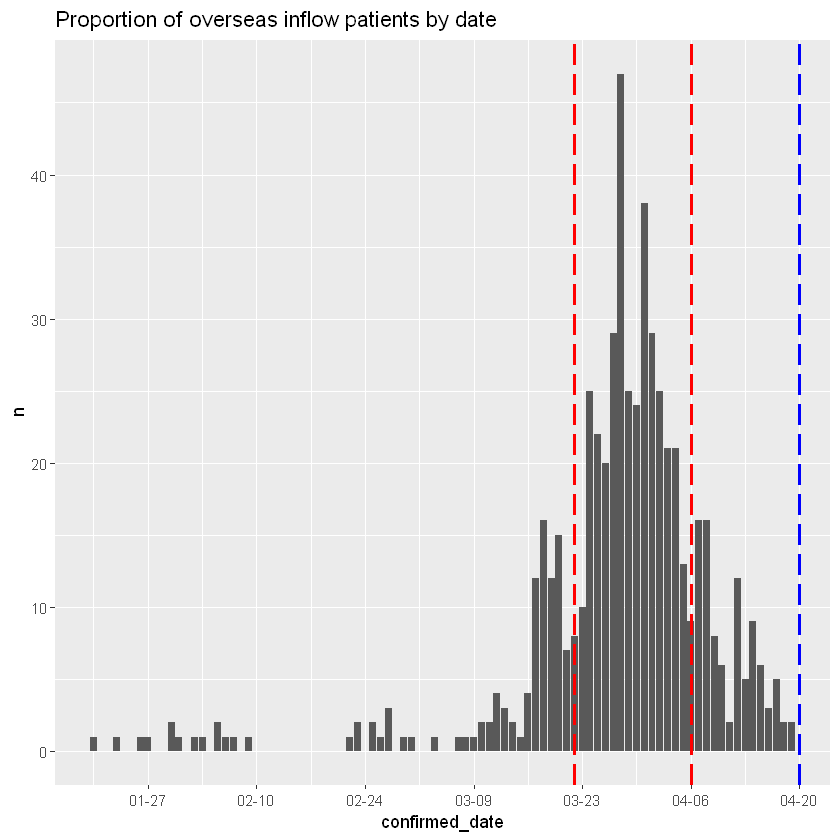

In [98]:
# 해외 유입 추이 변화 
patient_info %>%
 filter(infection_case=="overseas inflow") %>%
 group_by(confirmed_date) %>% summarize(n = n()) %>% 
 ggplot(aes(x=confirmed_date, y=n)) + 
 geom_bar(stat = "identity") +
 scale_x_date(date_breaks = "2 week", date_labels = "%m-%d") + 
 ggtitle("Proportion of overseas inflow patients by date")+
 geom_vline(xintercept = as.Date("2020-03-22", "%Y-%m-%d"), linetype="longdash",  color = "red", size=1)+
 geom_vline(xintercept = as.Date("2020-04-06", "%Y-%m-%d"), linetype="longdash",  color = "red", size=1)+
 geom_vline(xintercept = as.Date("2020-04-20", "%Y-%m-%d"), linetype="longdash",  color = "blue", size=1)